In [2]:
!pip install selenium pandas sqlalchemy sqlite-utils tqdm requests python-dotenv
# Optional (MySQL route)
!pip install pymysql
# For notebooks & EDA
!pip install jupyter matplotlib plotly seaborn

In [3]:
!python -m venv .venv/bin/activate

In [4]:
# src/scrape_cricsheet.py

import os, time, re, urllib.parse

from pathlib import Path

from selenium import webdriver

from selenium.webdriver.chrome.options import Options

from selenium.webdriver.common.by import By

from selenium.webdriver.support.ui import WebDriverWait

from selenium.webdriver.support import expected_conditions as EC
 
BASE_URL = "https://cricsheet.org/matches/"

DOWNLOAD_DIR = Path("data_raw").resolve()

DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)
 
FORMATS = {"Test", "ODI", "T20", "IPL"}  # adjust if needed
 
def main():

    opts = Options()

    opts.add_argument("--headless=new")

    driver = webdriver.Chrome(options=opts)

    driver.get(BASE_URL)
 
    wait = WebDriverWait(driver, 20)
 
    # Example: collect all links ending in .json or .zip (site may provide either)

    links = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'a[href]')))

    to_download = []

    for a in links:

        href = a.get_attribute("href") or ""

        text = (a.text or "").strip()

        if href.endswith(".json") or href.endswith(".zip"):

            # keep only if the anchor text or surrounding context mentions formats you want

            for f in FORMATS:

                if f.lower() in text.lower() or f.lower() in href.lower():

                    to_download.append(href)

                    break
 
    # De-duplicate

    to_download = sorted(set(to_download))

    print(f"Found {len(to_download)} files to download")
 
    # Use Selenium click (if needed) or fallback to requests (faster).

    import requests

    for url in to_download:

        fname = urllib.parse.unquote(url.split("/")[-1])

        out = DOWNLOAD_DIR / fname

        if out.exists(): 

            continue

        r = requests.get(url, timeout=60)

        r.raise_for_status()

        out.write_bytes(r.content)

        print("Saved:", out)
 
    driver.quit()
 
if __name__ == "__main__":

    main()

 

Found 10 files to download


In [4]:
for name, blob in iter_json_files():
    js = json.loads(blob.decode("utf-8", errors="ignore"))
    print("Sample innings structure for", name)
    print(js.get("innings")[0])   # show first innings
    break   # stop after first file

NameError: name 'iter_json_files' is not defined

In [6]:
def flatten_match(json_obj, match_id_hint):
    info = json_obj.get("info", {})
    outcome = info.get("outcome", {}) if isinstance(info.get("outcome", {}), dict) else {}
    by = outcome.get("by", {}) if isinstance(outcome, dict) else {}
 
    winner = outcome.get("winner") if isinstance(outcome, dict) else None
    dates = info.get("dates") or []
    match_date = str(dates[0]) if dates else None
 
    rec_match = {
        "match_id": match_id_hint,
        "match_type": info.get("match_type"),
        "date": match_date,
        "city": info.get("city"),
        "venue": info.get("venue"),
        "team1": (info.get("teams") or [None, None])[0],
        "team2": (info.get("teams") or [None, None])[1],
        "toss_winner": (info.get("toss") or {}).get("winner"),
        "toss_decision": (info.get("toss") or {}).get("decision"),
        "winner": winner,
        "win_by_runs": by.get("runs"),
        "win_by_wickets": by.get("wickets"),
    }
 
    deliv_rows = []
    innings_list = json_obj.get("innings") or []
 
    for inn_ix, inn in enumerate(innings_list, start=1):
        # Case A: { "1st innings": {...} }
        if isinstance(inn, dict) and len(inn) == 1 and isinstance(next(iter(inn.values())), dict):
            inn_dict = next(iter(inn.values()))
        # Case B: already { "team": ..., "overs": [...] }
        elif isinstance(inn, dict) and "overs" in inn:
            inn_dict = inn
        else:
            skipped.append((match_id_hint, inn_ix, f"Unexpected innings type: {type(inn).__name__}"))
            continue
 
        batting_team = inn_dict.get("team")
        if not batting_team:
            skipped.append((match_id_hint, inn_ix, "missing team"))
            continue
 
        for over in inn_dict.get("overs", []):
            over_no = over.get("over")
            for d in over.get("deliveries", []):
                runs = d.get("runs", {})
                wickets = d.get("wickets", []) or []
                wicket_kind = wickets[0].get("kind") if wickets else None
                player_out = wickets[0].get("player_out") if wickets else None
 
                deliv_rows.append({
                    "match_id": rec_match["match_id"],
                    "innings_no": inn_ix,
                    "over_no": over_no,
                    "ball_in_over": d.get("ball"),
                    "batting_team": batting_team,
                    "bowling_team": d.get("bowling_team"),
                    "striker": d.get("batter"),
                    "non_striker": d.get("non_striker"),
                    "bowler": d.get("bowler"),
                    "runs_batter": runs.get("batter", 0),
                    "runs_extras": runs.get("extras", 0),
                    "runs_total": runs.get("total", 0),
                    "wicket_kind": wicket_kind,
                    "player_out": player_out,
                    "is_boundary_4": 1 if runs.get("batter", 0) == 4 else 0,
                    "is_boundary_6": 1 if runs.get("batter", 0) == 6 else 0,
                })
 
    return rec_match, deliv_rows

In [7]:
import json, zipfile
from pathlib import Path
 
RAW = Path("data_raw")
 
def iter_json_files():
    for p in RAW.glob("*.json"):
        yield p.name, p.read_bytes()
    for zpath in RAW.glob("*.zip"):
        with zipfile.ZipFile(zpath, "r") as z:
            for name in z.namelist():
                if name.endswith(".json"):
                    yield name, z.read(name)
 
for name, blob in iter_json_files():
    js = json.loads(blob.decode("utf-8", errors="ignore"))
    print("➡ File:", name)
    print("➡ Innings field:")
    print(js.get("innings"))
    break   # only show the first file

➡ File: 1082591.json
➡ Innings field:
[{'team': 'Sunrisers Hyderabad', 'overs': [{'over': 0, 'deliveries': [{'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 4, 'extras': 0, 'total': 4}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'extras': {'wides': 2}, 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 2, 'total': 2}}, {'batter': 'S Dhawan', 'bowler': 'TS Mills', 'non_striker': 'DA Warner', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'S Dhawan', 'bowler': 'TS Mills', 'extras': {'legbyes': 1}, 'non_striker': 'DA Warner', 'runs': {'batter': 0, 'extras': 1, 't

In [7]:
import json, zipfile

from pathlib import Path
 
RAW = Path("data_raw")
 
def iter_json_files():

    for p in RAW.glob("*.json"):

        yield p.name, p.read_bytes()

    for zpath in RAW.glob("*.zip"):

        with zipfile.ZipFile(zpath, "r") as z:

            for name in z.namelist():

                if name.endswith(".json"):

                    yield name, z.read(name)
 
for name, blob in iter_json_files():

    js = json.loads(blob.decode("utf-8", errors="ignore"))

    print("➡ File:", name)

    print("➡ Innings field:")

    print(js.get("innings"))

    break   # only show the first file

 
# src/parse_json_to_df_final.py

import json, zipfile

from pathlib import Path

import pandas as pd

from tqdm import tqdm
 
RAW = Path("data_raw")

PARSED = Path("data_parsed")

PARSED.mkdir(exist_ok=True)
 
skipped = []  # collect unusual innings
 
 
def flatten_match(json_obj, match_id_hint):

    info = json_obj.get("info", {})

    outcome = info.get("outcome", {}) if isinstance(info.get("outcome", {}), dict) else {}

    by = outcome.get("by", {}) if isinstance(outcome, dict) else {}
 
    winner = outcome.get("winner") if isinstance(outcome, dict) else None

    dates = info.get("dates") or []

    match_date = str(dates[0]) if dates else None
 
    rec_match = {

        "match_id": match_id_hint,

        "match_type": info.get("match_type"),

        "date": match_date,

        "city": info.get("city"),

        "venue": info.get("venue"),

        "team1": (info.get("teams") or [None, None])[0],

        "team2": (info.get("teams") or [None, None])[1],

        "toss_winner": (info.get("toss") or {}).get("winner"),

        "toss_decision": (info.get("toss") or {}).get("decision"),

        "winner": winner,

        "win_by_runs": by.get("runs"),

        "win_by_wickets": by.get("wickets"),

    }
 
    deliv_rows = []

    innings_list = json_obj.get("innings") or []
 
    for inn_ix, inn in enumerate(innings_list, start=1):
 
        # Case A: { "1st innings": {...} }

        if isinstance(inn, dict) and len(inn) == 1 and isinstance(next(iter(inn.values())), dict):

            inn_dict = next(iter(inn.values()))
 
        # Case B: already {"team": ..., "overs": [...]}

        elif isinstance(inn, dict) and "overs" in inn:

            inn_dict = inn
 
        # Case C: weird → skip

        else:

            skipped.append((match_id_hint, inn_ix, f"Unexpected innings type: {inn}"))

            continue
 
        batting_team = inn_dict.get("team")

        if not batting_team:

            skipped.append((match_id_hint, inn_ix, "Missing team"))

            continue
 
        for over in inn_dict.get("overs", []):

            over_no = over.get("over")

            for d in over.get("deliveries", []):

                runs = d.get("runs", {})

                wickets = d.get("wickets", []) or []

                wicket_kind = wickets[0].get("kind") if wickets else None

                player_out = wickets[0].get("player_out") if wickets else None
 
                deliv_rows.append({

                    "match_id": rec_match["match_id"],

                    "innings_no": inn_ix,

                    "over_no": over_no,

                    "ball_in_over": d.get("ball"),

                    "batting_team": batting_team,

                    "bowling_team": d.get("bowling_team"),

                    "striker": d.get("batter"),

                    "non_striker": d.get("non_striker"),

                    "bowler": d.get("bowler"),

                    "runs_batter": runs.get("batter", 0),

                    "runs_extras": runs.get("extras", 0),

                    "runs_total": runs.get("total", 0),

                    "wicket_kind": wicket_kind,

                    "player_out": player_out,

                    "is_boundary_4": 1 if runs.get("batter", 0) == 4 else 0,

                    "is_boundary_6": 1 if runs.get("batter", 0) == 6 else 0,

                })
 
    return rec_match, deliv_rows
 
 
def iter_json_files():

    for p in RAW.glob("*.json"):

        yield p.name, p.read_bytes()

    for zpath in RAW.glob("*.zip"):

        with zipfile.ZipFile(zpath, "r") as z:

            for name in z.namelist():

                if name.endswith(".json"):

                    yield name, z.read(name)
 
 
def main():

    matches_rows, deliveries_rows = [], []
 
    for name, blob in tqdm(list(iter_json_files())):

        try:

            js = json.loads(blob.decode("utf-8"))

        except UnicodeDecodeError:

            js = json.loads(blob.decode("latin-1"))
 
        match_id = Path(name).stem

        rec, delivs = flatten_match(js, match_id)

        matches_rows.append(rec)

        deliveries_rows.extend(delivs)
 
    df_matches = pd.DataFrame(matches_rows)

    df_deliveries = pd.DataFrame(deliveries_rows)
 
    df_matches.to_parquet(PARSED / "matches.parquet", index=False)

    df_deliveries.to_parquet(PARSED / "deliveries.parquet", index=False)
 
    # summary

    print(f"[INFO] Parsed {len(df_matches)} matches, {len(df_deliveries)} deliveries")

    if skipped:

        df_skipped = pd.DataFrame(skipped, columns=["match_id", "innings_no", "reason"])

        df_skipped.to_csv(PARSED / "skipped_matches.csv", index=False)

        print(f"[INFO] {len(skipped)} innings skipped. See skipped_matches.csv")

    else:

        print("[INFO] No innings skipped.")
 
    print("✅ Saved parsed parquet files.")
 
 
if __name__ == "__main__":

    main()

 

➡ File: 1082591.json
➡ Innings field:
[{'team': 'Sunrisers Hyderabad', 'overs': [{'over': 0, 'deliveries': [{'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 4, 'extras': 0, 'total': 4}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'DA Warner', 'bowler': 'TS Mills', 'extras': {'wides': 2}, 'non_striker': 'S Dhawan', 'runs': {'batter': 0, 'extras': 2, 'total': 2}}, {'batter': 'S Dhawan', 'bowler': 'TS Mills', 'non_striker': 'DA Warner', 'runs': {'batter': 0, 'extras': 0, 'total': 0}}, {'batter': 'S Dhawan', 'bowler': 'TS Mills', 'extras': {'legbyes': 1}, 'non_striker': 'DA Warner', 'runs': {'batter': 0, 'extras': 1, 't

100%|██████████| 9856/9856 [00:38<00:00, 254.61it/s]


[INFO] Parsed 9856 matches, 4648874 deliveries
[INFO] No innings skipped.
✅ Saved parsed parquet files.


In [9]:
# src/load_to_sql.py

import pandas as pd

from pathlib import Path

from sqlalchemy import create_engine, text
 
PARSED = Path("data_parsed")
 
df_matches = pd.read_parquet(PARSED / "matches.parquet")

df_deliveries = pd.read_parquet(PARSED / "deliveries.parquet")
 
engine = create_engine("sqlite:///cricsheet.db", echo=False)
 
with engine.begin() as conn:

    # Optional: drop existing

    conn.exec_driver_sql("DROP TABLE IF EXISTS deliveries;")

    conn.exec_driver_sql("DROP TABLE IF EXISTS matches;")
 
    # Create tables with explicit schema (safer than relying on to_sql defaults)

    conn.exec_driver_sql("""

    CREATE TABLE matches (

      match_id TEXT PRIMARY KEY,

      match_type TEXT,

      date TEXT,

      city TEXT,

      venue TEXT,

      team1 TEXT, team2 TEXT,

      toss_winner TEXT, toss_decision TEXT,

      winner TEXT,

      win_by_runs INTEGER,

      win_by_wickets INTEGER

    );

    """)

    conn.exec_driver_sql("""

    CREATE TABLE deliveries (

      match_id TEXT,

      innings_no INTEGER,

      over_no INTEGER,

      ball_in_over REAL,

      batting_team TEXT,

      bowling_team TEXT,

      striker TEXT,

      non_striker TEXT,

      bowler TEXT,

      runs_batter INTEGER,

      runs_extras INTEGER,

      runs_total INTEGER,

      wicket_kind TEXT,

      player_out TEXT,

      is_boundary_4 INTEGER,

      is_boundary_6 INTEGER,

      FOREIGN KEY(match_id) REFERENCES matches(match_id)

    );

    """)
 
df_matches.to_sql("matches", con=engine, if_exists="append", index=False)

df_deliveries.to_sql("deliveries", con=engine, if_exists="append", index=False)
 
# Indexes speed up analysis

with engine.begin() as conn:

    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_deliv_match ON deliveries(match_id);")

    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_deliv_bats ON deliveries(striker);")

    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_deliv_bowl ON deliveries(bowler);")
 
print("Loaded into cricsheet.db")

 

Loaded into cricsheet.db


In [11]:
import mysql.connector
import getpass

user = input("Enter MySQL username: ")
password = getpass.getpass("Enter MySQL password: ")

conn = mysql.connector.connect(
    host="localhost",
    user=user,
    password=password,
    database="cricsheet_db"
)



Enter MySQL username:  root
Enter MySQL password:  ········


ProgrammingError: 1049 (42000): Unknown database 'cricsheet_db'

In [12]:
import mysql.connector
import getpass

user = input("Enter MySQL username: ")
password = getpass.getpass("Enter MySQL password: ")

conn = mysql.connector.connect(
    host="localhost",
    user=user,
    password=password,
    database="cricsheet_db"
)

print("✅ Connected successfully!")


Enter MySQL username:  root
Enter MySQL password:  ········


ProgrammingError: 1045 (28000): Access denied for user 'root'@'localhost' (using password: YES)

In [13]:
import sqlite3
import pandas as pd
 
# Connect to the SQLite DB
conn = sqlite3.connect("cricsheet.db")
 
# Example query: Top 10 ODI run-scorers
query = """
SELECT striker AS batsman, SUM(runs_batter) AS runs
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type = 'ODI'
GROUP BY striker
ORDER BY runs DESC
LIMIT 10;
"""
 
df = pd.read_sql_query(query, conn)
df

,batsman,runs
0,V Kohli,14059
1,KC Sangakkara,11618
2,RG Sharma,10948
3,MS Dhoni,10274
4,AB de Villiers,9435
5,TM Dilshan,9212
6,LRPL Taylor,8126
7,DPMD Jayawardene,8040
8,HM Amla,7834
9,Tamim Iqbal,7648


In [14]:
from sqlalchemy import create_engine
import pandas as pd
 
# SQLite engine
engine = create_engine("sqlite:///cricsheet.db")

In [16]:
# 2. Top 10 T20 wicket-takers
q2 = """
SELECT bowler, COUNT(*) AS wickets
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type = 'T20' AND wicket_kind IS NOT NULL
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 10;
"""
pd.read_sql(q2, engine)
python
Copy
Edit

NameError: name 'python' is not defined

In [17]:
import pandas as pd

query = """
SELECT striker AS batsman, SUM(runs_batter) AS runs
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY striker
ORDER BY runs DESC
LIMIT 10;
"""

df = pd.read_sql(query, engine)
print(df)


            batsman   runs
0           V Kohli  14059
1     KC Sangakkara  11618
2         RG Sharma  10948
3          MS Dhoni  10274
4    AB de Villiers   9435
5        TM Dilshan   9212
6       LRPL Taylor   8126
7  DPMD Jayawardene   8040
8           HM Amla   7834
9       Tamim Iqbal   7648


In [18]:
SELECT bowler, COUNT(*) AS wickets
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
  AND player_out IS NOT NULL   -- ensures it's a dismissal
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 10;


SyntaxError: unterminated string literal (detected at line 5) (3023687756.py, line 5)

In [19]:
query = """
SELECT bowler, COUNT(*) AS wickets
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
  AND player_out IS NOT NULL
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,bowler,wickets
0,SL Malinga,343
1,B Lee,281
2,Shakib Al Hasan,279
3,JM Anderson,268
4,Shahid Afridi,259
5,MA Starc,250
6,MG Johnson,243
7,RA Jadeja,243
8,TG Southee,230
9,Mashrafe Mortaza,227


In [21]:
query = """
SELECT striker AS batsman, COUNT(*) AS sixes
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI' 
  AND runs_batter = 6
GROUP BY striker
ORDER BY sixes DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,batsman,sixes
0,RG Sharma,338
1,CH Gayle,254
2,MS Dhoni,210
3,AB de Villiers,200
4,EJG Morgan,190
5,MJ Guptill,184
6,Shahid Afridi,177
7,JC Buttler,174
8,BB McCullum,172
9,V Kohli,154


In [22]:
query = """
SELECT striker AS batsman, COUNT(*) AS fours
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI' 
  AND runs_batter = 4
GROUP BY striker
ORDER BY fours DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,batsman,fours
0,V Kohli,1315
1,KC Sangakkara,1120
2,RG Sharma,1024
3,TM Dilshan,1022
4,Tamim Iqbal,841
5,S Dhawan,838
6,AB de Villiers,825
7,HM Amla,796
8,MS Dhoni,787
9,SR Tendulkar,774


In [23]:
query = """
SELECT striker AS batsman,
       SUM(runs_batter) AS runs,
       COUNT(*) AS balls_faced,
       ROUND(SUM(runs_batter) * 100.0 / COUNT(*), 2) AS strike_rate
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY striker
HAVING COUNT(*) >= 500   -- ensures min 500 balls faced
ORDER BY strike_rate DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,batsman,runs,balls_faced,strike_rate
0,Shahid Afridi,3913,2987,131.00
1,AD Russell,1034,805,128.45
2,GJ Maxwell,3695,3054,120.99
3,H Klaasen,2131,1839,115.88
4,Sharjeel Khan,787,692,113.73
5,JC Buttler,5232,4607,113.57
6,PD Salt,976,861,113.36
7,L Ronchi,1397,1241,112.57
8,MA Leask,1469,1311,112.05
9,MG Bracewell,757,682,111.00


In [24]:
query = """
SELECT bowler,
       SUM(runs_batter + runs_extras) AS runs_conceded,
       COUNT(*) AS balls_bowled,
       ROUND(SUM(runs_batter + runs_extras) / (COUNT(*)/6), 2) AS economy
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY bowler
HAVING COUNT(*) >= 600   -- min 100 overs (600 balls)
ORDER BY economy ASC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,bowler,runs_conceded,balls_bowled,economy
0,A Vala,1320,2017,3.0
1,AR Caddick,389,604,3.0
2,Aamir Kaleem,411,681,3.0
3,Anam Amin,730,1139,3.0
4,BM Scholtz,1707,3073,3.0
5,BTJ Wheal,414,630,3.0
6,D Hazell,904,1375,3.0
7,D van Niekerk,1526,2575,3.0
8,DL Vettori,5322,7996,3.0
9,E Bisht,1293,1970,3.0


In [25]:
query = """
SELECT bowler,
       COUNT(*) AS wickets
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
  AND player_out IS NOT NULL   -- only when a wicket falls
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,bowler,wickets
0,SL Malinga,343
1,B Lee,281
2,Shakib Al Hasan,279
3,JM Anderson,268
4,Shahid Afridi,259
5,MA Starc,250
6,MG Johnson,243
7,RA Jadeja,243
8,TG Southee,230
9,Mashrafe Mortaza,227


In [37]:
query = """
SELECT striker AS batsman1,
       non_striker AS batsman2,
       SUM(runs_batter + runs_extras) AS partnership_runs
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY striker, non_striker
ORDER BY partnership_runs DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,batsman1,batsman2,partnership_runs
0,KC Sangakkara,TM Dilshan,2745
1,S Dhawan,RG Sharma,2727
2,RG Sharma,V Kohli,2692
3,V Kohli,RG Sharma,2574
4,DPMD Jayawardene,KC Sangakkara,2568
5,KC Sangakkara,DPMD Jayawardene,2559
6,TM Dilshan,KC Sangakkara,2546
7,RG Sharma,S Dhawan,2464
8,AC Gilchrist,ML Hayden,2351
9,Q de Kock,HM Amla,2187


In [38]:
query = """
SELECT bowler,
       SUM(runs_total) * 1.0 / (COUNT(*) / 6.0) AS economy,
       COUNT(*)/6 AS overs_bowled
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY bowler
HAVING overs_bowled >= 100
ORDER BY economy ASC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,bowler,economy,overs_bowled
0,Shakeel Ahmed,3.118605,143
1,S Molineux,3.318108,102
2,BM Scholtz,3.332899,512
3,MM Letsoalo,3.358621,145
4,SM Pollock,3.445169,843
5,IJR Zwilling,3.448753,120
6,S Loubser,3.450237,105
7,D van Niekerk,3.555728,429
8,Aamir Kaleem,3.621145,113
9,J Nkomo,3.621849,119


In [39]:
query = """
SELECT d.striker AS batsman,
       d.match_id,
       SUM(d.runs_batter) AS runs_in_match
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY d.match_id, d.striker
ORDER BY runs_in_match DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,batsman,match_id,runs_in_match
0,RG Sharma,792295,264
1,MJ Guptill,656489,237
2,V Sehwag,536932,219
3,CH Gayle,656427,215
4,Fakhar Zaman,1142923,210
5,Ishan Kishan,1340847,210
6,RG Sharma,647261,209
7,RG Sharma,1122727,208
8,Shubman Gill,1348646,208
9,SR Tendulkar,441828,200


In [40]:
query = """
SELECT d.match_id,
       d.batting_team,
       SUM(d.runs_total) AS team_total
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY d.match_id, d.batting_team
ORDER BY team_total DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,match_id,batting_team,team_total
0,1281444,England,498
1,1119539,England,481
2,913657,England,444
3,722341,South Africa,439
4,238200,South Africa,438
5,903601,South Africa,438
6,1459899,India,435
7,238200,Australia,434
8,1384395,South Africa,428
9,1145892,New Zealand,418


In [41]:
query = """
SELECT d.match_id,
       d.bowler,
       COUNT(d.player_out) AS wickets,
       SUM(d.runs_total) AS runs_conceded
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY d.match_id, d.bowler
HAVING wickets > 0
ORDER BY wickets DESC, runs_conceded ASC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,match_id,bowler,wickets,runs_conceded
0,645635,Shahid Afridi,7,14
1,1276296,S Lamichhane,7,14
2,65263,GD McGrath,7,15
3,1412541,PWH de Silva,7,19
4,65269,AJ Bichel,7,20
5,1428959,C Cassell,7,21
6,1168024,EA Perry,7,23
7,1377748,PWH de Silva,7,24
8,1415982,C Murray,7,31
9,1365104,Ali Khan,7,33


In [43]:
query = """
SELECT d.match_id,
       d.bowler,
       COUNT(d.player_out) AS wickets
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
  AND d.player_out IS NOT NULL
GROUP BY d.match_id, d.bowler
ORDER BY wickets DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,match_id,bowler,wickets
0,1020017,TA Boult,7
1,1115796,TA Boult,7
2,1153846,TG Southee,7
3,1168024,EA Perry,7
4,1233463,B Muzarabani,7
5,1276296,S Lamichhane,7
6,1365104,Ali Khan,7
7,1377748,PWH de Silva,7
8,1384437,Mohammed Shami,7
9,1412541,PWH de Silva,7


In [45]:
query = """
SELECT bowler,
       COUNT(*) AS maiden_overs
FROM (
    SELECT d.match_id, d.innings_no, d.over_no, d.bowler,
           SUM(d.runs_total) AS runs_in_over
    FROM deliveries d
    JOIN matches m ON d.match_id = m.match_id
    WHERE m.match_type = 'ODI'
    GROUP BY d.match_id, d.innings_no, d.over_no, d.bowler
    HAVING runs_in_over = 0
) AS maiden_data
GROUP BY bowler
ORDER BY maiden_overs DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,bowler,maiden_overs
0,SM Pollock,115
1,JM Anderson,108
2,KD Mills,98
3,B Lee,97
4,KMDN Kulasekara,91
5,SL Malinga,89
6,WPUJC Vaas,88
7,Shakib Al Hasan,77
8,TG Southee,75
9,Mashrafe Mortaza,74


In [46]:
query = """
SELECT d.bowler,
       d.match_id,
       COUNT(*) AS wickets
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
  AND d.player_out IS NOT NULL   -- only count dismissals
GROUP BY d.match_id, d.bowler
ORDER BY wickets DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,bowler,match_id,wickets
0,TA Boult,1020017,7
1,TA Boult,1115796,7
2,TG Southee,1153846,7
3,EA Perry,1168024,7
4,B Muzarabani,1233463,7
5,S Lamichhane,1276296,7
6,Ali Khan,1365104,7
7,PWH de Silva,1377748,7
8,Mohammed Shami,1384437,7
9,PWH de Silva,1412541,7


In [47]:
query = """
SELECT d.bowler,
       SUM(d.runs_total) * 6.0 / COUNT(*) AS economy_rate,
       COUNT(*) AS balls_bowled
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY d.bowler
HAVING balls_bowled >= 500
ORDER BY economy_rate ASC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,bowler,economy_rate,balls_bowled
0,T van der Gugten,3.107143,504
1,Shakeel Ahmed,3.118605,860
2,S Molineux,3.318108,613
3,BM Scholtz,3.332899,3073
4,MM Letsoalo,3.358621,870
5,SM Pollock,3.445169,5061
6,IJR Zwilling,3.448753,722
7,S Loubser,3.450237,633
8,K Ndlovu,3.517241,580
9,D van Niekerk,3.555728,2575


In [48]:
query = """
SELECT d.match_id,
       d.innings_no,
       d.striker,
       d.non_striker,
       SUM(d.runs_batter + d.runs_extras) AS partnership_runs
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY d.match_id, d.innings_no, d.striker, d.non_striker
ORDER BY partnership_runs DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,match_id,innings_no,striker,non_striker,partnership_runs
0,656427,1,CH Gayle,MN Samuels,226
1,1340847,1,Ishan Kishan,V Kohli,204
2,1168508,1,JD Campbell,SD Hope,188
3,1000895,1,DA Warner,TM Head,180
4,1142923,1,Fakhar Zaman,Imam-ul-Haq,180
5,1214669,1,Liton Das,Tamim Iqbal,180
6,1168508,1,SD Hope,JD Campbell,177
7,749789,1,L Ronchi,GD Elliott,171
8,1075504,2,Q de Kock,HM Amla,170
9,225254,2,ST Jayasuriya,WU Tharanga,167


In [49]:
query = """
SELECT winner,
       COUNT(*) AS wins
FROM matches
WHERE match_type = 'ODI'
  AND winner IS NOT NULL
GROUP BY winner
ORDER BY wins DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,winner,wins
0,Australia,382
1,India,374
2,England,302
3,South Africa,295
4,Sri Lanka,243
5,New Zealand,242
6,Pakistan,233
7,West Indies,171
8,Bangladesh,138
9,Zimbabwe,69


In [59]:
query = """
SELECT city,
       COUNT(*) AS matches_hosted
FROM matches
WHERE match_type = 'ODI'
  AND city IS NOT NULL
GROUP BY city
ORDER BY matches_hosted DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,city,matches_hosted
0,Colombo,125
1,London,90
2,Mirpur,84
3,Harare,75
4,Bulawayo,60
5,Dubai,56
6,Dublin,49
7,Lahore,48
8,Centurion,45
9,Karachi,44


In [61]:
query = """
SELECT bowler,
       COUNT(*) AS bowled_wickets
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
  AND wicket_kind = 'bowled'
GROUP BY bowler
ORDER BY bowled_wickets DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, conn)
df


,bowler,bowled_wickets
0,SL Malinga,96
1,MA Starc,83
2,Shahid Afridi,69
3,B Lee,62
4,Mohammed Shami,60
5,RA Jadeja,59
6,JM Anderson,56
7,Shakib Al Hasan,55
8,S Ismail,50
9,TA Boult,49


C:\Users\Kiran Kumar\AppData\Local\Temp\ipykernel_18480\1367256060.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




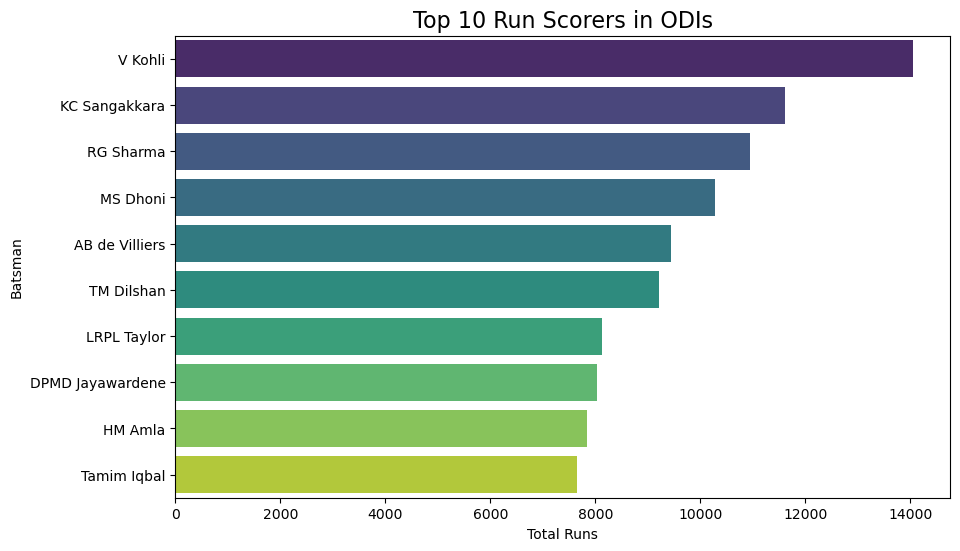

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from sqlalchemy import create_engine
# DB Connection

engine = create_engine("sqlite:///cricsheet.db")
 

# Query to fetch total runs by batsmen in ODIs
query1 = """
SELECT striker AS batsman,
       SUM(runs_batter) AS total_runs
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY striker
ORDER BY total_runs DESC
LIMIT 10;
"""

df = pd.read_sql_query(query1, conn)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="total_runs", y="batsman", data=df, palette="viridis")
plt.title("Top 10 Run Scorers in ODIs", fontsize=16)
plt.xlabel("Total Runs")
plt.ylabel("Batsman")
plt.show()


C:\Users\Kiran Kumar\AppData\Local\Temp\ipykernel_18480\140365480.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




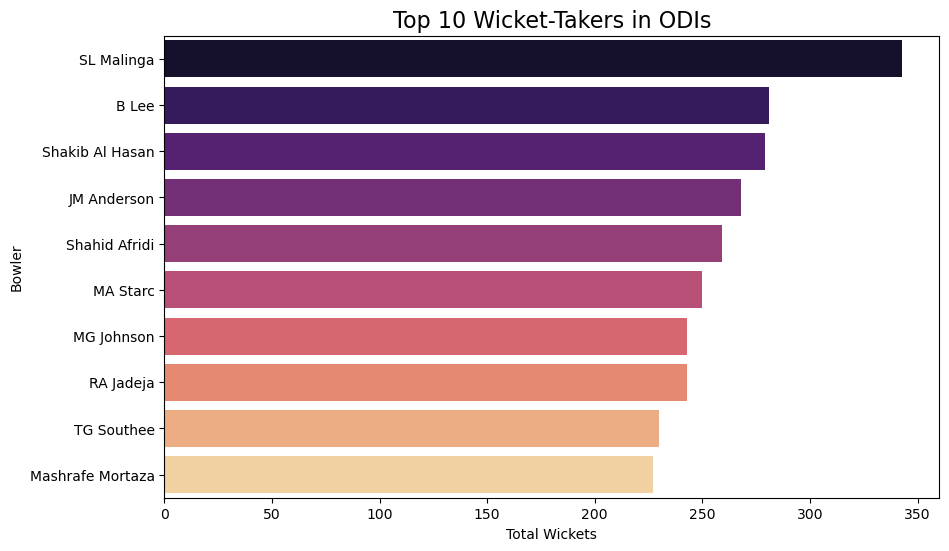

In [86]:
# Query to fetch top wicket-takers in ODIs
query2 = """
SELECT bowler,
       COUNT(*) AS wickets
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
  AND player_out IS NOT NULL
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 10;
"""

df = pd.read_sql_query(query2, conn)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="wickets", y="bowler", data=df, palette="magma")
plt.title("Top 10 Wicket-Takers in ODIs", fontsize=16)
plt.xlabel("Total Wickets")
plt.ylabel("Bowler")
plt.show()


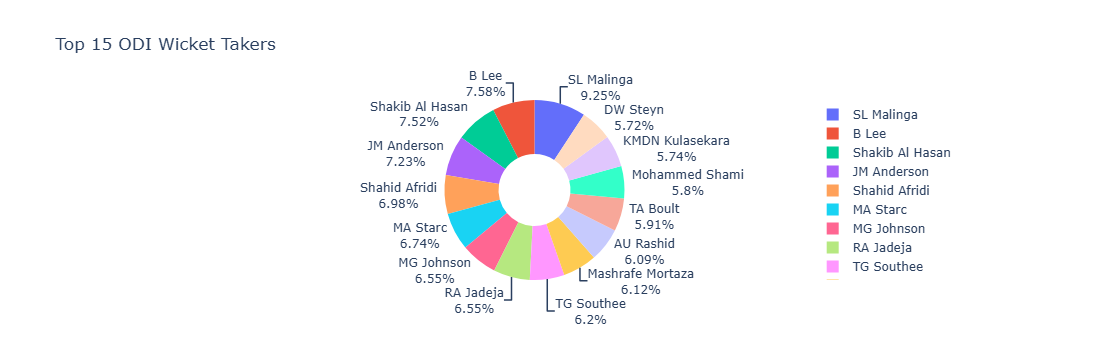

In [94]:
import plotly.express as px
 
query3 = """
SELECT bowler, COUNT(*) AS wickets
FROM deliveries d JOIN matches m USING(match_id)
WHERE m.match_type='ODI' AND wicket_kind IS NOT NULL
GROUP BY bowler
ORDER BY wickets DESC
LIMIT 15;
"""
df = pd.read_sql(query3, engine)
 
fig = px.pie(
    df,
    names="bowler", 
    values="wickets", 
    title="Top 15 ODI Wicket Takers",
    hole=0.4  # use 0 for normal pie, 0.4 for donut style
)
fig.update_traces(textinfo="percent+label")  # show % and name
fig.show()



C:\Users\Kiran Kumar\AppData\Local\Temp\ipykernel_18480\3762122334.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




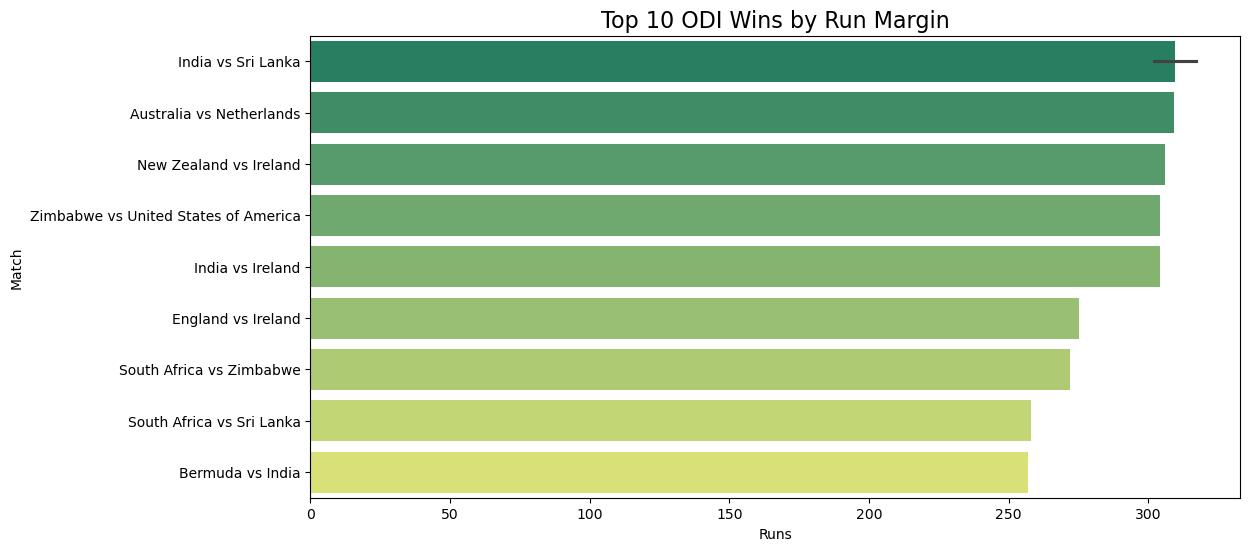

In [88]:
# Query for top 10 matches by win margin (runs)
query4 = """
SELECT team1 || ' vs ' || team2 AS match, win_by_runs
FROM matches
WHERE match_type = 'ODI'
ORDER BY win_by_runs DESC
LIMIT 10;
"""

df = pd.read_sql_query(query4, conn)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="win_by_runs", y="match", data=df, palette="summer")
plt.title("Top 10 ODI Wins by Run Margin", fontsize=16)
plt.xlabel("Runs")
plt.ylabel("Match")
plt.show()


C:\Users\Kiran Kumar\AppData\Local\Temp\ipykernel_18480\2371319724.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




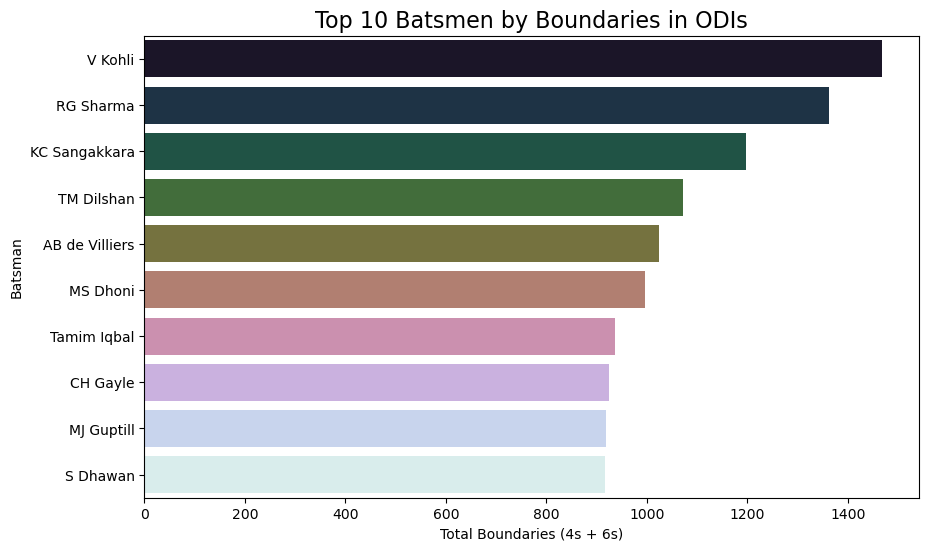

In [89]:
# Query to fetch top batsmen by boundaries
query5 = """
SELECT striker AS batsman,
       SUM(is_boundary_4 + is_boundary_6) AS total_boundaries
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY striker
ORDER BY total_boundaries DESC
LIMIT 10;
"""

df = pd.read_sql_query(query5, conn)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="total_boundaries", y="batsman", data=df, palette="cubehelix")
plt.title("Top 10 Batsmen by Boundaries in ODIs", fontsize=16)
plt.xlabel("Total Boundaries (4s + 6s)")
plt.ylabel("Batsman")
plt.show()


C:\Users\Kiran Kumar\AppData\Local\Temp\ipykernel_18480\2399720856.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




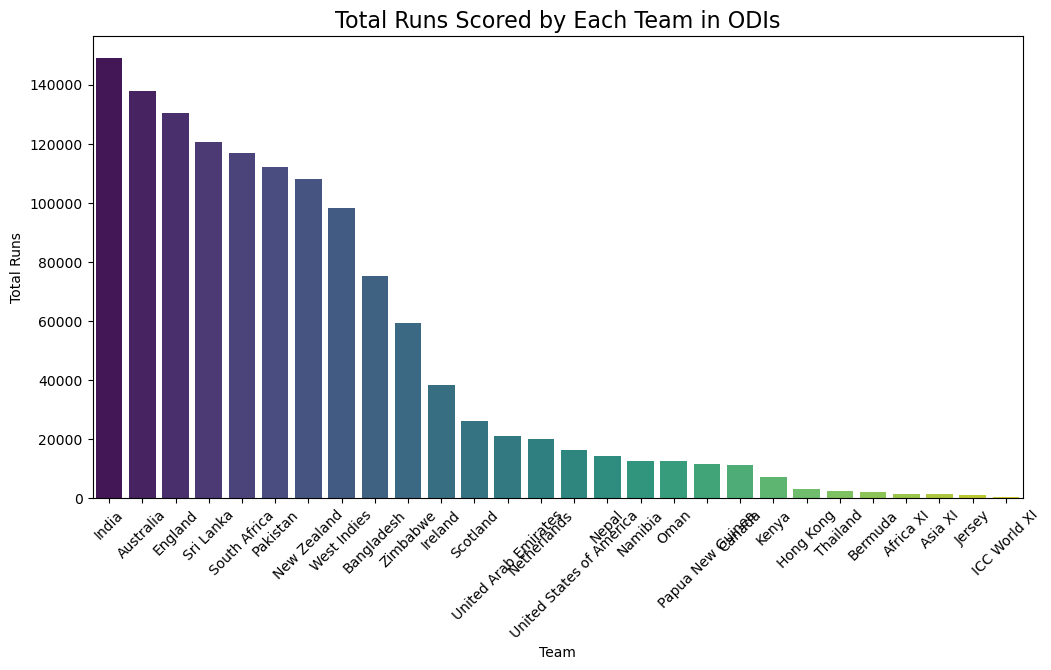

In [90]:
# Query to fetch total runs by each team in ODIs
query6 = """
SELECT batting_team AS team,
       SUM(runs_total) AS total_runs
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY batting_team
ORDER BY total_runs DESC;
"""

df = pd.read_sql_query(query6, conn)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="team", y="total_runs", data=df, palette="viridis")
plt.title("Total Runs Scored by Each Team in ODIs", fontsize=16)
plt.xlabel("Team")
plt.ylabel("Total Runs")
plt.xticks(rotation=45)
plt.show()


C:\Users\Kiran Kumar\AppData\Local\Temp\ipykernel_18480\1684556631.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




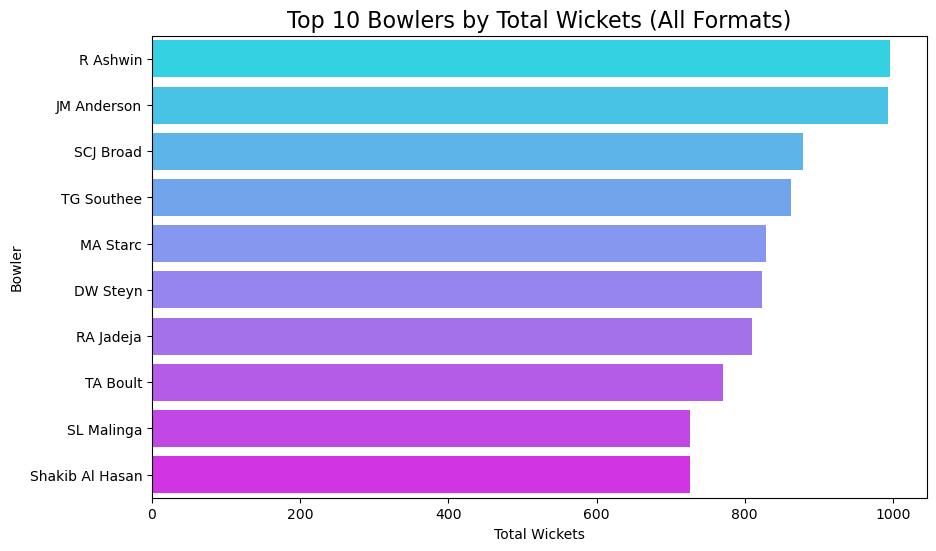

In [91]:
# Query to fetch top bowlers by wickets across all formats
query7 = """
SELECT bowler,
       COUNT(*) AS total_wickets
FROM deliveries d
WHERE player_out IS NOT NULL
GROUP BY bowler
ORDER BY total_wickets DESC
LIMIT 10;
"""

df = pd.read_sql_query(query7, conn)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="total_wickets", y="bowler", data=df, palette="cool")
plt.title("Top 10 Bowlers by Total Wickets (All Formats)", fontsize=16)
plt.xlabel("Total Wickets")
plt.ylabel("Bowler")
plt.show()


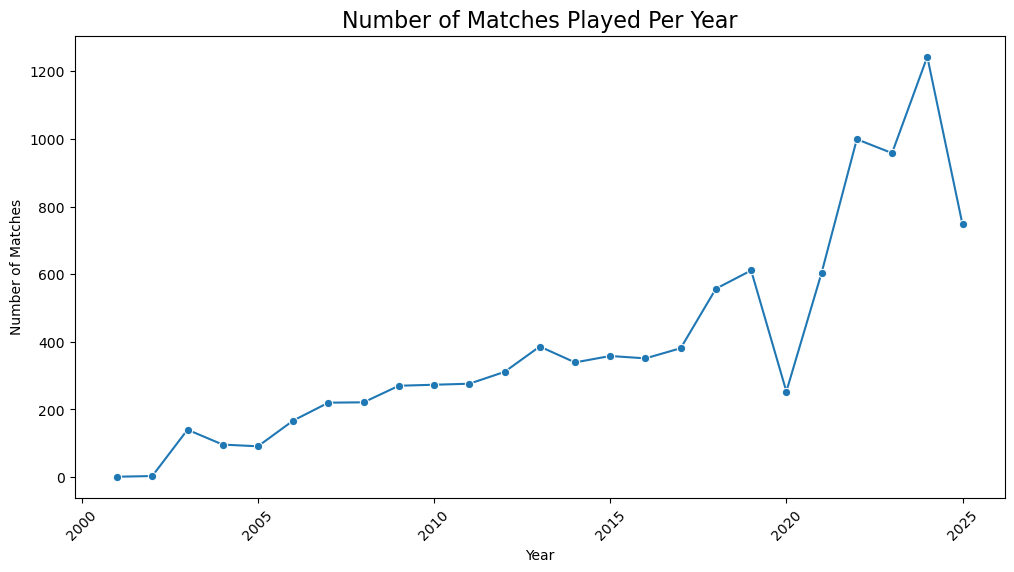

In [70]:
# 8.Convert date to datetime if not already
matches_df = pd.read_sql_query("SELECT date FROM matches;", conn)
matches_df['date'] = pd.to_datetime(matches_df['date'], errors='coerce')
matches_df['year'] = matches_df['date'].dt.year

# Count matches per year
matches_per_year = matches_df.groupby('year').size().reset_index(name='matches')

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x='year', y='matches', data=matches_per_year, marker='o')
plt.title("Number of Matches Played Per Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.show()


C:\Users\Kiran Kumar\AppData\Local\Temp\ipykernel_18480\166271948.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




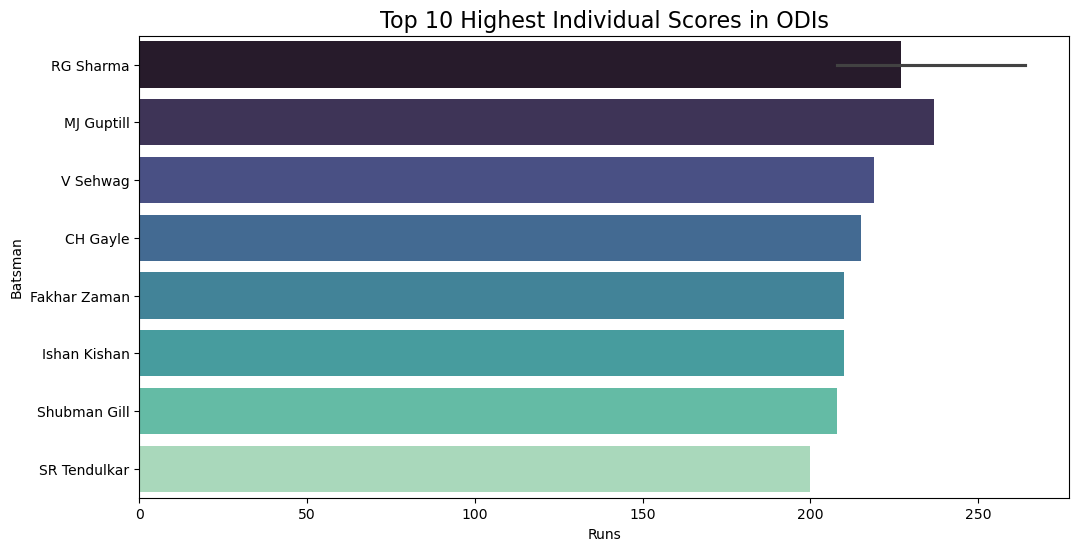

In [92]:
# Query to calculate total runs per batsman per match in ODIs (fixed)
query9 = """
SELECT d.striker AS batsman,
       d.match_id,
       SUM(COALESCE(d.runs_batter, 0)) AS total_runs
FROM deliveries d
JOIN matches m ON d.match_id = m.match_id
WHERE m.match_type = 'ODI'
GROUP BY d.match_id, d.striker
ORDER BY total_runs DESC
LIMIT 10;
"""

df = pd.read_sql_query(query9, conn)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="total_runs", y="batsman", data=df, palette="mako")
plt.title("Top 10 Highest Individual Scores in ODIs", fontsize=16)
plt.xlabel("Runs")
plt.ylabel("Batsman")
plt.show()


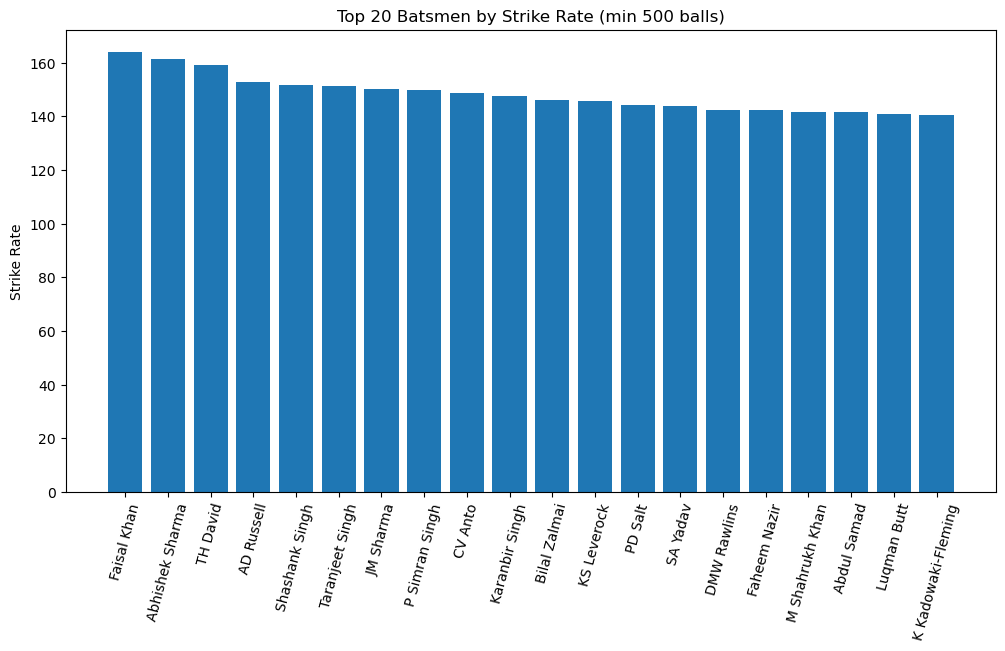

C:\Users\Kiran Kumar\AppData\Local\Temp\ipykernel_18480\1624098342.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




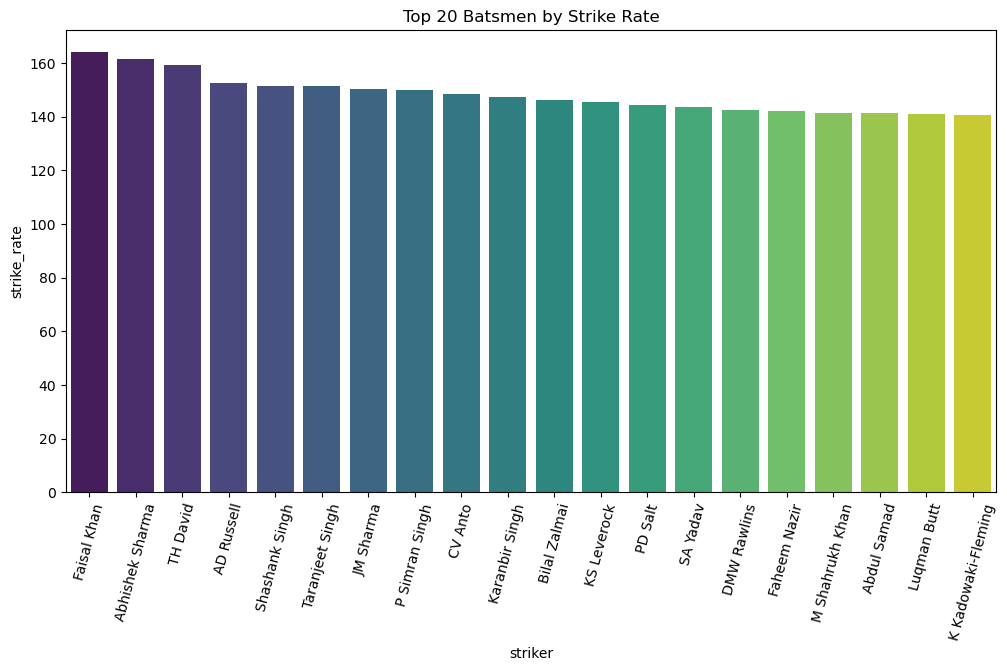

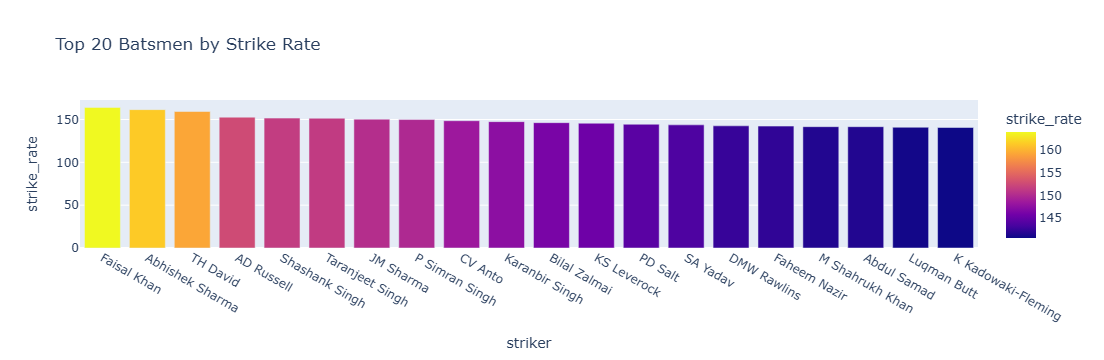

In [93]:
query10 = """
SELECT striker, 
       SUM(runs_batter) * 100.0 / COUNT(*) AS strike_rate,
       COUNT(*) AS balls
FROM deliveries
GROUP BY striker
HAVING balls >= 500
ORDER BY strike_rate DESC
LIMIT 20;
"""
df = pd.read_sql(query10, engine)
 
# Matplotlib
plt.figure(figsize=(12,6))
plt.bar(df['striker'], df['strike_rate'])
plt.xticks(rotation=75)
plt.ylabel("Strike Rate")
plt.title("Top 20 Batsmen by Strike Rate (min 500 balls)")
plt.show()
 
# Seaborn
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="striker", y="strike_rate", palette="viridis")
plt.xticks(rotation=75)
plt.title("Top 20 Batsmen by Strike Rate")
plt.show()
 
# Plotly
px.bar(df, x="striker", y="strike_rate", title="Top 20 Batsmen by Strike Rate", 
       hover_data=["balls"], color="strike_rate")

In [1]:
# Export matches table
df_matches.to_csv("matches.csv", index=False)

# Export deliveries table
df_deliveries.to_csv("deliveries.csv", index=False)


NameError: name 'df_matches' is not defined

In [2]:
# Check all variables in memory
%whos


Interactive namespace is empty.


In [3]:
# Example if your matches table is in df
df.to_csv("matches.csv", index=False)

# Example if your deliveries table is in odi_df
odi_df.to_csv("deliveries.csv", index=False)


NameError: name 'df' is not defined

In [4]:
import sqlite3
import pandas as pd

# Connect to SQLite DB (or MySQL if you use MySQL)
conn = sqlite3.connect("cricsheet.db")


In [5]:
# Matches table
df_matches = pd.read_sql_query("SELECT * FROM matches;", conn)

# Deliveries table
df_deliveries = pd.read_sql_query("SELECT * FROM deliveries;", conn)


In [6]:
df_matches.head()
df_deliveries.head()


,match_id,innings_no,over_no,ball_in_over,batting_team,bowling_team,striker,non_striker,bowler,runs_batter,runs_extras,runs_total,wicket_kind,player_out,is_boundary_4,is_boundary_6
0,1082591,1,0,None,Sunrisers Hyderabad,None,DA Warner,S Dhawan,TS Mills,0,0,0,None,None,0,0
1,1082591,1,0,None,Sunrisers Hyderabad,None,DA Warner,S Dhawan,TS Mills,0,0,0,None,None,0,0
2,1082591,1,0,None,Sunrisers Hyderabad,None,DA Warner,S Dhawan,TS Mills,4,0,4,None,None,1,0
3,1082591,1,0,None,Sunrisers Hyderabad,None,DA Warner,S Dhawan,TS Mills,0,0,0,None,None,0,0
4,1082591,1,0,None,Sunrisers Hyderabad,None,DA Warner,S Dhawan,TS Mills,0,2,2,None,None,0,0


In [7]:
df_matches.to_csv("matches.csv", index=False)
df_deliveries.to_csv("deliveries.csv", index=False)


In [8]:
import os
print(os.getcwd())


C:\Users\Kiran Kumar\Desktop\Cricksheet_Match_Analysis1


In [9]:
print(os.path.exists("matches.csv"))
print(os.path.exists("deliveries.csv"))


True
True


In [10]:
pd.read_csv("matches.csv").head()
pd.read_csv("deliveries.csv").head()


,match_id,innings_no,over_no,ball_in_over,batting_team,bowling_team,striker,non_striker,bowler,runs_batter,runs_extras,runs_total,wicket_kind,player_out,is_boundary_4,is_boundary_6
0,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN,0,0
1,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN,0,0
2,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,4,0,4,NaN,NaN,1,0
3,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,0,0,0,NaN,NaN,0,0
4,1082591,1,0,NaN,Sunrisers Hyderabad,NaN,DA Warner,S Dhawan,TS Mills,0,2,2,NaN,NaN,0,0


In [12]:
# Matches table
df_matches = pd.read_sql_query("SELECT * FROM matches;", conn)
# Deliveries table
df_deliveries = pd.read_sql_query("SELECT * FROM deliveries;", conn)
 
# innings table
# Matches table
df_matches = pd.read_sql_query("SELECT * FROM matches;", conn)
# Deliveries table
df_deliveries = pd.read_sql_query("SELECT * FROM deliveries;", conn)
 
# innings table
#df_innings = pd.read_sql_query("SELECT * FROM innings;", conn)